In [13]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [66]:

data_dir = pathlib.Path(train_dir)


In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

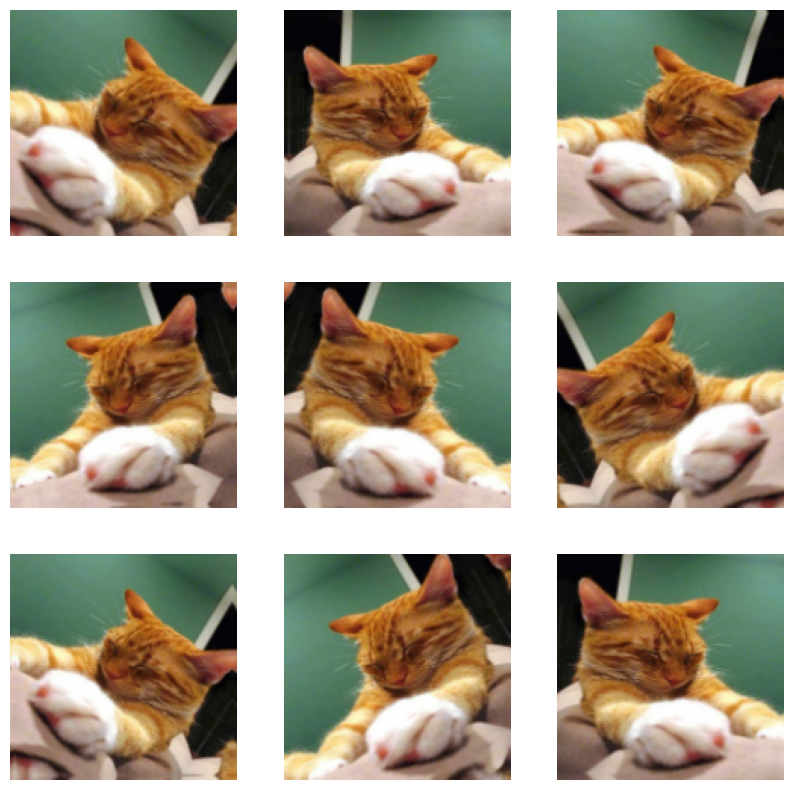

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [24]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                  

In [27]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
19/19 [==============================] - 21s 970ms/step - loss: 0.7800 - accuracy: 0.5217 - val_loss: 0.6907 - val_accuracy: 0.5267
Epoch 2/5
19/19 [==============================] - 24s 1s/step - loss: 0.6866 - accuracy: 0.5625 - val_loss: 0.6839 - val_accuracy: 0.5333
Epoch 3/5
19/19 [==============================] - 20s 1s/step - loss: 0.6773 - accuracy: 0.5825 - val_loss: 0.6650 - val_accuracy: 0.5800
Epoch 4/5
19/19 [==============================] - 21s 1s/step - loss: 0.6436 - accuracy: 0.6388 - val_loss: 0.6397 - val_accuracy: 0.6617
Epoch 5/5
19/19 [==============================] - 21s 1s/step - loss: 0.6173 - accuracy: 0.6758 - val_loss: 0.6109 - val_accuracy: 0.6533


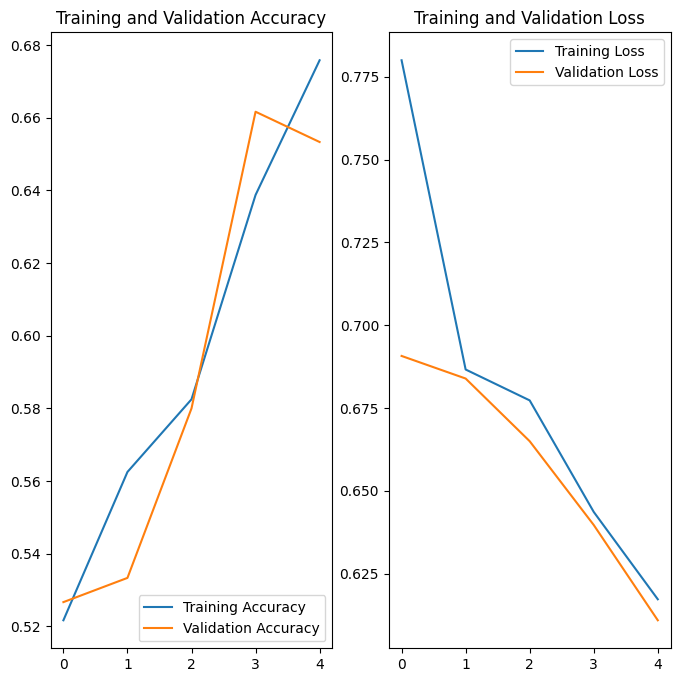

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [115]:
tester = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    class_names=['cats', 'dogs'],
    color_mode="rgb",
    batch_size=128,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 50 files belonging to 2 classes.


In [116]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [117]:
predictions = probability_model.predict(tester)

1/1 [==============================] - 0s 138ms/step


Predictions:
 [0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1
 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0]
Labels:
 [1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 0]


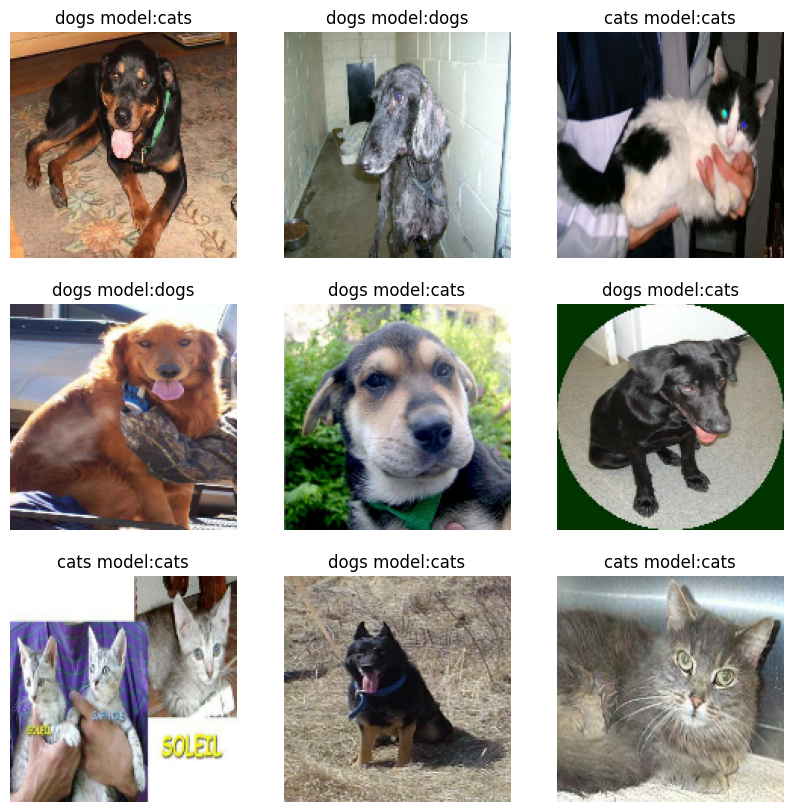

In [133]:
# Retrieve a batch of images from the test set
image_batch, label_batch = tester.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]] + ' model:' + class_names[predictions[i]])
  
  plt.axis("off")